In [1]:
#|default_exp conv

# Convolutions

In [2]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from little_ai.training import *
from little_ai.datasets import *

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Kernels

In [6]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [7]:
mpl.rcParams['figure.dpi'] = 30

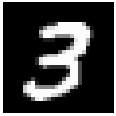

In [8]:
im3 = x_imgs[7]
show_image(im3);

In [9]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

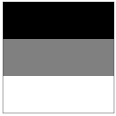

In [10]:
show_image(top_edge, noframe=False);

In [11]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [12]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [13]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [14]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [15]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

In [16]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

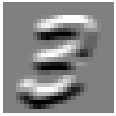

In [17]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

In [18]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

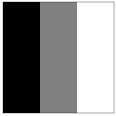

In [19]:
show_image(left_edge, noframe=False);

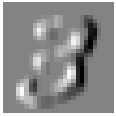

In [20]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

## Convolutions in PyTorch

In [21]:
import torch.nn.functional as F
import torch

In [22]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [23]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [24]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

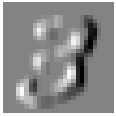

In [25]:
out = out_unf.view(26,26)
show_image(out);

In [26]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

The slowest run took 33.17 times longer than the fastest. This could mean that an intermediate result is being cached.
34.6 ms ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

56.4 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 217.12 times longer than the fastest. This could mean that an intermediate result is being cached.
405 µs ± 922 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

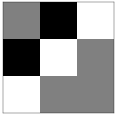

In [30]:
show_image(diag1_edge, noframe=False);

In [31]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

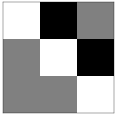

In [32]:
show_image(diag2_edge, noframe=False);

In [33]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [34]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [35]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

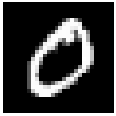

In [36]:
img0 = xb[1,0]
show_image(img0);

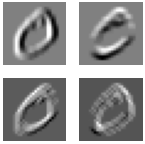

In [37]:
show_images([batch_features[1,i] for i in range(4)])

# Creating the CNN

In [38]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [39]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [40]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [41]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [42]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [43]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
)

In [44]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [45]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

In [46]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [47]:
from torch import optim

In [48]:
bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [49]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch:0, loss:0.5505139010429382, accuracy:0.8246
epoch:1, loss:0.1794444365501404, accuracy:0.9475
epoch:2, loss:0.17415035572052, accuracy:0.9464
epoch:3, loss:0.5114139924526214, accuracy:0.8354
epoch:4, loss:0.126976012031734, accuracy:0.96


In [50]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

epoch:0, loss:0.08930072996616363, accuracy:0.9729
epoch:1, loss:0.0841722670868039, accuracy:0.975
epoch:2, loss:0.08902569960057735, accuracy:0.9744
epoch:3, loss:0.08268870219439269, accuracy:0.9761
epoch:4, loss:0.08247650600150228, accuracy:0.9754


## Understanding Convolution Arithmetic

In [51]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [52]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [53]:
conv1.bias.shape

torch.Size([4])

# Export

In [54]:
import nbdev; nbdev.nbdev_export()